In [1]:
import cv2
import numpy as np
import scipy
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt

In [5]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Load query image
query_img_path = "datasets/drone_1/images/query/DJI_0003 copy.jpeg"
query_img = cv2.imread(query_img_path)

query_gs = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)
print(query_gs.shape)

# Load reference image
ref_img_path = "datasets/drone_1/images/mapping/rgb_1920x1440_00000.jpeg"
ref_img = cv2.imread(ref_img_path)
ref_height, ref_width = ref_img.shape[:2]

# Downsample reference image
downsample_ratio = 0.08
ds_h, ds_w = int(np.ceil(ref_height*downsample_ratio)), int(np.ceil(ref_width*downsample_ratio))

downsampled_img = cv2.resize(ref_img, (ds_w, ds_h))
downsampled_img = scipy.ndimage.rotate(downsampled_img, 90) #cv2.rotate(downsampled_img, 270)

#kernel = cv2.cvtColor(downsampled_img, cv2.COLOR_RGB2GRAY)
#small_k = np.ones((3,3),np.float32)/10
#kernel = cv2.filter2D(kernel,-1,small_k)

#cv2.imshow('image',downsampled_img)
#cv2.waitKey(0)


(709, 855)


In [ ]:
# Moving window and perform convolution
out = query_gs.copy()

out = scipy.ndimage.convolve(query_gs, kernel)

# show results

In [ ]:
h, w = kernel.shape
qh, qw = query_gs.shape
out = np.zeros((qh, qw))

mse_t=80

print(h, w, qh-h, qw-w)
ys = []
for i in range(int(np.ceil(w/2))+1,qw-int(w/2)-1):
    for j in range(int(np.ceil(h/2))+1,qh-int(h/2)-1):
        #print(i+w, j+h)
        X = query_gs[j-int(h/2):j+int(h/2), i-int(w/2):i+int(w/2)]
        
        if X.shape[0] != kernel.shape[0] or X.shape[1] != kernel.shape[1]:
            continue

        #print(i, j, X.shape, kernel.shape)
        print(X.shape, kernel.shape)
        Y=np.convolve(X, kernel)
        print(Y)
        #Y = np.square(np.subtract(X,kernel)).mean()
        ys.append(Y)
        
        if Y < mse_t:
            print(f"Threshold less than {mse_t}.")
            cv2.imshow('image',X)
            cv2.waitKey(0)
        out[j,i] = Y
    print(f"{i}: Avg Y: {np.sum(np.array(ys))/len(ys)}, min: {np.min(np.array(ys))}, max:{np.max(np.array(ys))}")
#out = NormalizeData(out)

(96, 72) 0.05
(154, 116) 0.08
(192, 144) 0.1
(231, 173) 0.12
(288, 216) 0.15
(384, 288) 0.2


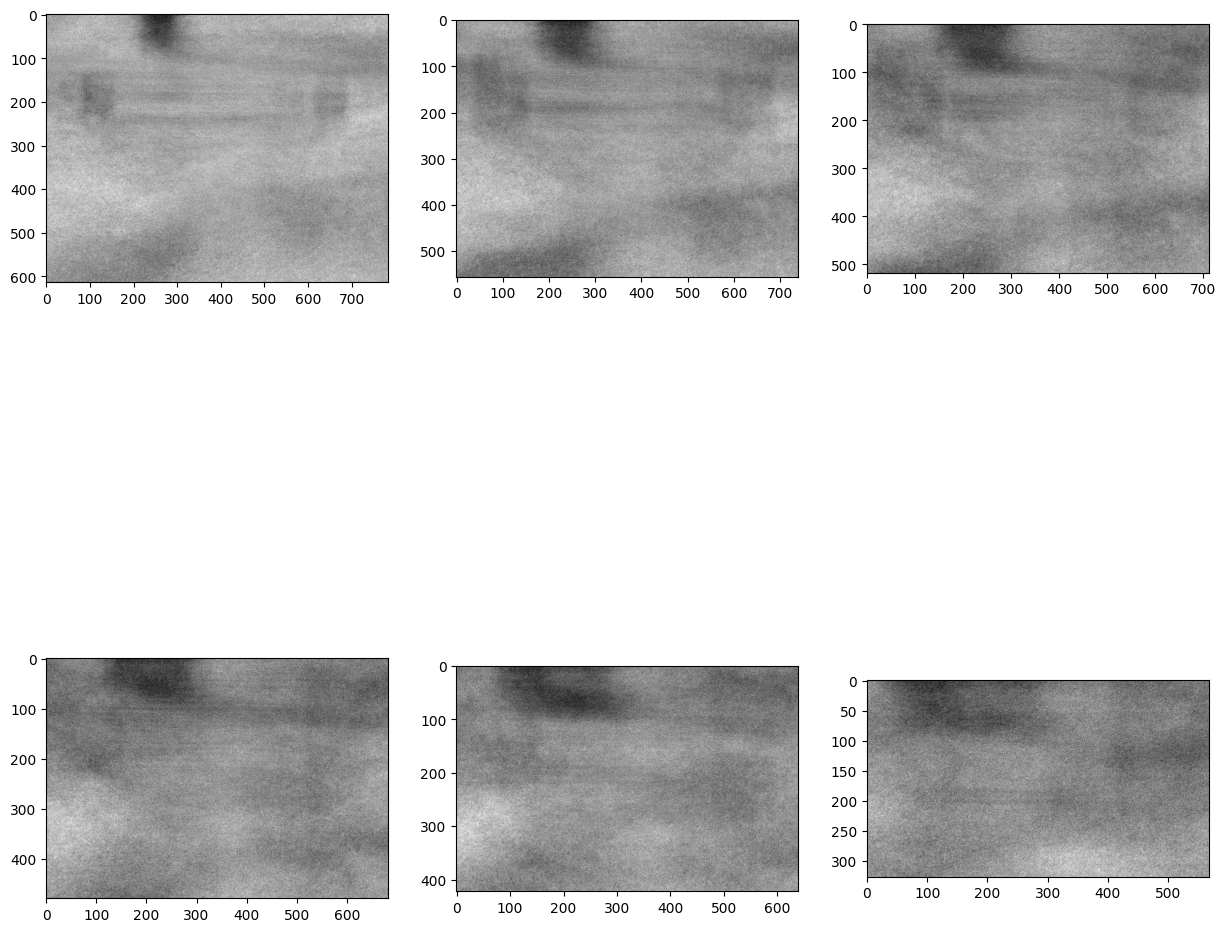

In [6]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

ds_ratios = [0.05, 0.08, 0.1, 0.12, 0.15, 0.2]

f, axarr = plt.subplots(2,3, figsize=(15, 15))

for i, ratio in enumerate(ds_ratios):
    # Downsample reference image
    
    ds_h, ds_w = int(np.ceil(ref_height*ratio)), int(np.ceil(ref_width*ratio))
  
    kernel = cv2.resize(ref_img, (ds_w, ds_h))
    kernel = scipy.ndimage.rotate(kernel, 90) #cv2.rotate(downsampled_img, 270)
    kernel = cv2.cvtColor(kernel, cv2.COLOR_RGB2GRAY)
    
    print(kernel.shape, ratio)
    out = convolve2D(query_gs, kernel)
    axarr[int(np.floor(i/3)), i%3].imshow(NormalizeData(out), cmap=plt.get_cmap('gray'))

In [ ]:

print(np.max(kernel), np.min(kernel))
print(np.max(query_gs), np.min(query_gs))
print(np.max(out))
print(np.min(out))


print(NormalizeData(out))

In [ ]:
f, axarr = plt.subplots(2,2, figsize=(15, 15))
axarr[0,0].imshow(ref_img)
axarr[0,1].imshow(kernel, cmap=plt.get_cmap('gray'))
axarr[1,0].imshow(query_gs, cmap=plt.get_cmap('gray'))
axarr[1,1].imshow(out, cmap=plt.get_cmap('gray'))